In [50]:
import os
import pandas as pd
import joblib

random_seed = 1234
DATA_DIR = '/Users/malithidesilva/fyp'
RESULT_DIR = '/Users/malithidesilva/fyp/model_1'

features_list = pd.read_csv(os.path.join(DATA_DIR, 'features_REDISCOVER.csv'))
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'REDISCOVER_Rearranged_Cleaned_withNA_withFRS.csv'))


# Separate feature, metadata, outcome from df
features = features_list[features_list['Types'] == 'features']
metadata = features_list[features_list['Types'] == 'metadata']
outcomes = features_list[features_list['Types'] == 'outcome']

os.makedirs(RESULT_DIR, exist_ok=True)

### Data Preparation

In [51]:
features_excluded = []

# Separate data according to stats type: categorical, binary, continuous and ordinal
categorical_data = features[features['Stats Type'] == 'categorical']['Variables'].to_list()
binary_data = features[features['Stats Type'] == 'binary_categorical']['Variables'].to_list()
continuous_data = features[features['Stats Type'] == 'continuous']['Variables'].to_list()
ordinal_data = features[features['Stats Type'] == 'ordinal']['Variables'].to_list()

# Fill Null value with 999
# raw_data.fillna(999, inplace=True)

raw_data_lessThan3Years = raw_data[raw_data['year_diff'] <= 3]
# raw_data_lessThan3Years = raw_data[raw_data['outcome'] < 3]
raw_data_lessThan3Years.loc[raw_data_lessThan3Years['outcome'] > 1, 'outcome'] = 1
raw_data_lessThan3Years = raw_data_lessThan3Years.drop_duplicates()
# raw_data_lessThan3Years = raw_data_lessThan3Years.drop(columns=features_excluded)
raw_data_lessThan3Years = raw_data_lessThan3Years.iloc[:, 2:]

In [34]:
class_0_data = raw_data_lessThan3Years[raw_data_lessThan3Years['outcome']==0]#.dropna()
# class_0_data = class_0_data.sample(n=500)
class_1_data = raw_data_lessThan3Years[raw_data_lessThan3Years['outcome']==1]

print('No CVD:', class_0_data.shape, 'CVD:', class_1_data.shape)

encoded_raw_data = pd.concat([class_0_data, class_1_data], axis=0)

encoded_raw_data['outcome'].astype('category')

# Map binary data into 0 and 1
for variable in binary_data:
    if variable == 'menopause':
       encoded_raw_data.loc[:, variable] = encoded_raw_data[variable].map({1: 1, 2: 0, 3:0})
    else:
       encoded_raw_data.loc[:, variable] = encoded_raw_data[variable].map({1: 1, 2: 0})

# Label encoding for categorical columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for variable in categorical_data:
    encoded_raw_data.loc[:, variable] = label_encoder.fit_transform(encoded_raw_data[variable])
    encoded_raw_data.loc[:, variable] = encoded_raw_data[variable].astype('category')

# Normalize continuous datam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

def get_normalized_data(data):
    scaler = MinMaxScaler()
    scaled_data = data.copy()  # Create a copy of the data to avoid modifying the original DataFrame

    for variable in continuous_data:
        # Reshape data to 2D array for the scaler
        data_array = data[[variable]].values.reshape(-1, 1)
        # Apply the scaler
        scaled_data.loc[:, variable] = scaler.fit_transform(data_array)

    return scaled_data

No CVD: (11373, 58) CVD: (140, 58)


/var/folders/_7/kb2yf8nn19qfw7gq6f2tl1400000gn/T/ipykernel_54400/2833143851.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0, 0.0, 2.0, 0.0, 1.0, ..., 2.0, 2.0, 2.0, 2.0, 2.0]
Length: 11513
Categories (4, float64): [0.0, 1.0, 2.0, 3.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  encoded_raw_data.loc[:, variable] = encoded_raw_data[variable].astype('category')
/var/folders/_7/kb2yf8nn19qfw7gq6f2tl1400000gn/T/ipykernel_54400/2833143851.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 0.0, ..., 1.0, 1.0, 1.0, 2.0, 1.0]
Length: 11513
Categories (4, float64): [0.0, 1.0, 2.0, 3.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  encoded_raw_data.loc[:, variable] = encoded_raw_data[variable].astype('category')
/var/folders/_7/kb

## Stratified Splitting

70% training, 15% testing, 15% calibration

In [52]:
split_raw_data = encoded_raw_data

from sklearn.model_selection import train_test_split

excluded_col_for_training = outcomes['Variables'].to_list()
excluded_col_for_training.extend(metadata['Variables'].to_list())

# Split the data into features and target
X = split_raw_data.drop(excluded_col_for_training, axis=1)
y = split_raw_data['outcome']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)
X_test, X_calib, y_test, y_calib = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify=y_temp)

print(f'------------------ Splitting Data: ------------------')
print(f'Original: {X.shape} splitted into -> test: {X_test.shape}, train: {X_train.shape}, calib: {X_calib.shape}')
print(f'Testing set (%): {X_test.shape[0] / X.shape[0]}')
print(f'Training set (%): {X_train.shape[0] / X.shape[0]}')
print(f'Calibration set (%): {X_calib.shape[0] / X.shape[0]}')

print(pd.DataFrame([y_train.value_counts(), y_test.value_counts(), y_calib.value_counts()], index=['train', 'test', 'calib']))

joblib.dump(
    {
        'X_train': X_train,
        'y_train': y_train,
        'X_test':X_test,
        'y_test': y_test,
        'X_calib': X_calib,
        'y_calib': y_calib,
    }, os.path.join(RESULT_DIR, 'train_test_data.pkl'))

frs_df = split_raw_data[['FRS_score_coeff3', 'FRS_outcome', 'FRS_score']]
X_train_frs = frs_df.loc[X_train.index]
X_test_frs = frs_df.loc[X_test.index]
X_calib_frs = frs_df.loc[X_calib.index]
y_train_frs = frs_df.loc[y_train.index]
y_test_frs = frs_df.loc[y_test.index]
y_calib_frs = frs_df.loc[y_calib.index]

joblib.dump(
    {
        'X_train_frs': X_train_frs,
        'X_test_frs': X_test_frs,
        'X_calib_frs': X_calib_frs,
        'y_train_frs': y_train_frs,
        'y_test_frs': y_test_frs,
        'y_calib_frs': y_calib_frs,
    }, os.path.join(RESULT_DIR, 'frs_data.pkl'))

------------------ Splitting Data: ------------------
Original: (11513, 48) splitted into -> test: (1727, 48), train: (8059, 48), calib: (1727, 48)
Testing set (%): 0.15000434291670287
Training set (%): 0.6999913141665943
Calibration set (%): 0.15000434291670287
outcome     0   1
train    7961  98
test     1706  21
calib    1706  21


['/Users/malithidesilva/fyp/model_1/frs_data.pkl']

## Imputation

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# imputer = IterativeImputer(max_iter=200, tol=1e-3, random_state=random_seed)
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)
X_calib_imputed = imputer.fit_transform(X_calib)

joblib.dump({
    'X_train_imputed': X_train_imputed,
    'y_train': y_train,
    'X_test_imputed':X_test_imputed,
    'y_test': y_test,
    'X_calib_imputed':X_calib_imputed,
    'y_calib': y_calib,
}, os.path.join(RESULT_DIR, 'imputed_data.pkl'))

['/Users/malithidesilva/fyp/model_1/final/imputed_data.pkl']

## Balancing

In [38]:
# Define the balancing method
balancing_method = 'smote'  # Change to 'ros' to use Random Over-Sampling

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

rus = RandomUnderSampler(sampling_strategy={0: 200})  # Adjust the majority class to a smaller size
X_rus, y_rus = rus.fit_resample(X_train_imputed, y_train)

# Apply the selected balancing method
if balancing_method == 'ros':
    ros = RandomOverSampler(sampling_strategy='not majority')  # This will oversample all classes except the majority
    X_balanced, y_balanced = ros.fit_resample(X_rus, y_rus)
elif balancing_method == 'smote':
    smote = SMOTE(random_state=random_seed)
    X_balanced, y_balanced = smote.fit_resample(X_rus, y_rus)

print('RUS:', X_rus.shape, y_rus.shape)
print('Balanced:', X_balanced.shape, y_balanced.shape)

joblib.dump({
    'X_balanced': X_balanced,
    'y_balanced': y_balanced,
    'X_rus': X_rus,
    'y_rus': y_rus,
    'X_test_selected': X_test_imputed,
    'y_test': y_test,
}, os.path.join(RESULT_DIR, f'resampled_data_{balancing_method}.pkl'))

joblib.dump({
    'X_train_selected': X_balanced,
    'y_train_selected': y_balanced,
    'X_test_selected': X_test_imputed,
    'y_test_selected': y_test,
    'X_calib_selected': X_calib_imputed,
    'y_calib_selected': y_calib,
}, os.path.join(RESULT_DIR, f'full_selected_data.pkl'))


RUS: (298, 48) (298,)
Balanced: (400, 48) (400,)


['/Users/malithidesilva/fyp/model_1/final/full_selected_data.pkl']

## Feature Selection

### 1. RFE

In [39]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

estimators = {
    'rf': RandomForestClassifier(random_state=random_seed), 
    # 'lr': LogisticRegression(random_state=random_seed, max_iter=1000)
}

for est_name, estimator in estimators.items():
    rfe = RFE(estimator, n_features_to_select=10)
    # rfe = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    X_train_rfe = rfe.fit_transform(X_balanced, y_balanced)
    X_test_rfe = rfe.transform(X_test_imputed)
    X_calib_rfe = rfe.transform(X_calib_imputed)

    print(X_train_rfe.shape, X_test_rfe.shape,X_calib_rfe.shape, y_calib.shape, y_balanced.shape, y_test.shape)

    features = X_train.columns

    selected_features_mask = rfe.support_

    # Get rankings
    feature_ranking = rfe.ranking_

    fet_ranking = pd.DataFrame({
        'Feature': features,
        'Selected': selected_features_mask,
        'Ranking': feature_ranking
    })

    FET_EXTRACTION_DIR = os.path.join(RESULT_DIR, 'fet_extraction')
    if not os.path.exists(FET_EXTRACTION_DIR):
        os.makedirs(FET_EXTRACTION_DIR)

    fet_ranking.to_csv(os.path.join(FET_EXTRACTION_DIR, f'rfe_fet_ranking_{est_name}.csv'))

    selected_10_features = pd.read_csv(os.path.join(FET_EXTRACTION_DIR, f'rfe_fet_ranking_{est_name}.csv'))

    selected_10_features = selected_10_features[selected_10_features['Selected'] == True]['Feature']
    print(selected_10_features)
    joblib.dump({
        'est_name' : 'rf',
        'X_train_rfe': X_train_rfe,
        'y_train_selected': y_balanced,
        'X_test_rfe': X_test_rfe,
        'y_test_selected': y_test,
        'X_calib_rfe': X_calib_rfe,
        'y_calib_selected': y_calib,
    }, os.path.join(RESULT_DIR, f'selected_fet_data_RFE_{est_name}.pkl'))



(400, 10) (1727, 10) (1727, 10) (1727,) (400,) (1727,)
0                 area
2                  age
7                  bmi
8                  bps
9                  bpd
12               waist
13                 whr
30    glucose_baseline
33        hdl_baseline
47                PERF
Name: Feature, dtype: object


In [40]:
data = joblib.load(os.path.join(RESULT_DIR, 'full_selected_data.pkl'))
X_train_selected = data['X_train_selected']
y_train_selected = data['y_train_selected']
X_test_selected = data['X_test_selected']
y_test_selected = data['y_test_selected']
X_calib_selected = data['X_calib_selected']
y_calib_selected = data['y_calib_selected']

## 2. Backward elimination

In [41]:
import joblib
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

sffs = SequentialFeatureSelector(LinearRegression(),
         n_features_to_select=10,
         direction='forward',
         cv=5)
sffs.fit(X_train_selected, y_train_selected)

print(sffs.n_features_to_select_)
print(sffs.support_)
selected_fet = []
unselected_fet = []
for idx, fet in enumerate(X_train.columns.to_list()):
    if sffs.support_[idx]:
        selected_fet.append(fet)
    else:
        unselected_fet.append(fet)
        

selected_fet

joblib.dump({
    'features' : selected_fet
}, os.path.join(RESULT_DIR, f'selected_10fet_forward.pkl'))
X_train_transformed = sffs.transform(X_train_selected)
print(X_train_transformed.shape)

# X_test_transformed = sffs.transform(X_test_selected)
# print(X_test_transformed.shape)

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import joblib
import numpy as np


def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    removed_features = {}
    all_features_iteration = {}
    all_features = []
    print(f'Fet num: {len(features)}')
    while(len(features)>0):
        features_with_constant = add_constant(data[features].values)
        # print(features_with_constant.shape)
        p_values = OLS(target, features_with_constant).fit().pvalues[1:]
        
        max_p_value = p_values.max()
        excluded_feature_index = p_values.argmax()
        excluded_feature = features[excluded_feature_index]

        all_features_iteration = {features[i]: p_values[i] for i in range(len(features))}
        all_features.append(all_features_iteration)

        if(max_p_value >= significance_level):
            # print('feature excluded:', excluded_feature, max_p_value)
            removed_features[excluded_feature] = max_p_value
            features.remove(excluded_feature)
        else:
            break 

    return features, removed_features, all_features

features, removed_features, all_features  = backward_elimination(pd.DataFrame(X_train_selected, columns=X_train.columns), y_train_selected)


10
[ True False False False False False False False False  True False False
 False False False  True False False  True  True False False False  True
 False False  True False False False False False False False False  True
 False False  True False False False  True False False False False False]
(400, 10)
Fet num: 48


/var/folders/_7/kb2yf8nn19qfw7gq6f2tl1400000gn/T/ipykernel_54400/1255865249.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_features_iteration = {features[i]: p_values[i] for i in range(len(features))}
/var/folders/_7/kb2yf8nn19qfw7gq6f2tl1400000gn/T/ipykernel_54400/1255865249.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_features_iteration = {features[i]: p_values[i] for i in range(len(features))}
/var/folders/_7/kb2yf8nn19qfw7gq6f2tl1400000gn/T/ipykernel_54400/1255865249.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

In [42]:
pd.DataFrame.from_dict(removed_features, orient='index', columns=['pvalues']).to_csv(os.path.join(RESULT_DIR, f'be_removed_features_pvalues.csv'))

### Iteratively Remove Each Feature and Test AUC 

* For Assessing only


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Convert numpy arrays to pandas DataFrames
X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_test.columns)
X_calib_selected_df = pd.DataFrame(X_calib_selected, columns=X_calib.columns)

# Function to compute AUC with a given set of features
def compute_auc(X, y, model):
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    return auc

def compute_test_auc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_prob)

# Define the model
model = RandomForestClassifier(random_state=random_seed)

# Calculate the AUC with all features
initial_auc = compute_auc(X_train_selected_df, y_train_selected, model)
initial_test_auc = compute_test_auc(model, X_train_selected_df, y_train_selected, X_test_selected_df, y_test_selected)
print(f'Initial Train AUC with all features: {initial_auc}')
print(f'Initial Test AUC with all features: {initial_test_auc}')

# Test AUC for each feature removed
feature_auc = {}
feature_test_auc = {}
for feature in X_train_selected_df.columns:
    X_temp = X_train_selected_df.drop(columns=[feature])
    auc = compute_auc(X_temp, y_train_selected, model)
    test_auc = compute_test_auc(model, X_temp, y_train_selected, X_test_selected_df.drop(columns=[feature]), y_test_selected)
    feature_auc[feature] = auc
    feature_test_auc[feature] = test_auc
    print(f'AUC without {feature}: {auc}, Test AUC without {feature}: {test_auc}')

# Save the AUC results
feature_auc_df = pd.DataFrame.from_dict(feature_auc, orient='index', columns=['AUC'])
feature_test_auc_df = pd.DataFrame.from_dict(feature_test_auc, orient='index', columns=['Test_AUC'])
feature_auc_df = feature_auc_df.join(feature_test_auc_df)
feature_auc_df.to_csv(os.path.join(RESULT_DIR, 'feature_auc_removal.csv'))

# Print features that reduce the AUC significantly when removed
print("\nFeatures that reduce AUC significantly when removed:")
print(feature_auc_df[(feature_auc_df['AUC'] < initial_auc) | (feature_auc_df['Test_AUC'] < initial_test_auc)].sort_values(by='AUC', ascending=True))

Initial Train AUC with all features: 0.911875
Initial Test AUC with all features: 0.8235080667671523
AUC without area: 0.9044375, Test AUC without area: 0.8047507396862614
AUC without gender: 0.9163125000000001, Test AUC without gender: 0.8233685033216099
AUC without age: 0.9106249999999999, Test AUC without age: 0.8111148328029922
AUC without menopause: 0.9150625, Test AUC without menopause: 0.8323563892145369
AUC without smoking: 0.9133125, Test AUC without smoking: 0.8461592139786747
AUC without weight: 0.9165000000000001, Test AUC without weight: 0.8377156255233629
AUC without height: 0.9115, Test AUC without height: 0.8446798414559258
AUC without bmi: 0.92225, Test AUC without bmi: 0.8381622285490984
AUC without bps: 0.9196249999999999, Test AUC without bps: 0.8283788310165802
AUC without bpd: 0.9193125, Test AUC without bpd: 0.8231452018087422
AUC without pulse: 0.91175, Test AUC without pulse: 0.8288673030759783
AUC without hip: 0.9178749999999999, Test AUC without hip: 0.844986

### 3. Remove Highly correlated Features

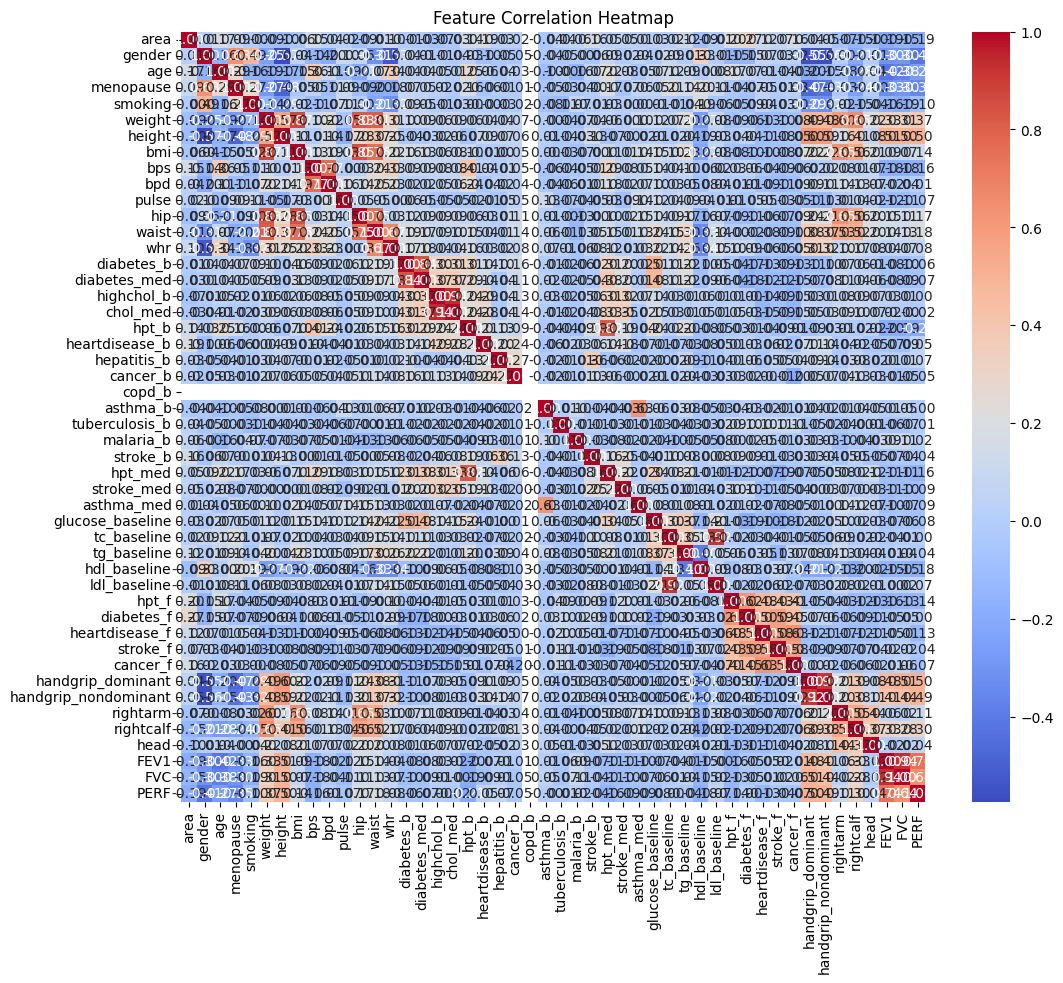

Features removed due to high correlation:
chol_med
ldl_baseline
handgrip_nondominant
Highly correlated features removed and data saved.


In [44]:
# Set the correlation threshold
correlation_threshold = 0.9

# Compute the correlation matrix
correlation_matrix = X_train_selected_df.corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.savefig(os.path.join(RESULT_DIR, 'feature_correlation_heatmap.png'))
plt.show()

# Save the correlation matrix
correlation_matrix.to_csv(os.path.join(RESULT_DIR, 'feature_correlation_matrix.csv'))

# Identify highly correlated features
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_correlation_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column].abs() > correlation_threshold)
]

# Ensure 'FVC' is not removed
if 'FVC' in high_correlation_features:
    high_correlation_features.remove('FVC')

# Print out the features that were removed
print("Features removed due to high correlation:")
for feature in high_correlation_features:
    print(feature)

# Drop highly correlated features
X_train_reduced = X_train_selected_df.drop(columns=high_correlation_features)
X_test_reduced = X_test_selected_df.drop(columns=high_correlation_features)
X_calib_reduced = X_calib_selected_df.drop(columns=high_correlation_features)

# Save the reduced dataset
reduced_data = {
    'X_train_reduced': X_train_reduced,
    'y_train_selected': y_train_selected,
    'X_test_reduced': X_test_reduced,
    'y_test_selected': y_test_selected,
    'X_calib_reduced': X_calib_reduced,
    'y_calib_selected': y_calib_selected,
}
joblib.dump(reduced_data, os.path.join(RESULT_DIR, 'reduced_data.pkl'))

print("Highly correlated features removed and data saved.")


### 4. Shap Based Feature Selection

* train the initial balanced sample to identify best features 

In [45]:
# Assuming `X_train` is already defined and contains your original training data
# Extract column names from X_train
column_names = X_train.columns.tolist()

# Now you can use these column names when creating your DataFrames for the selected data
X_train_selected = pd.DataFrame(data['X_train_selected'], columns=column_names)
y_train_selected = pd.Series(data['y_train_selected'])
X_test_selected = pd.DataFrame(data['X_test_selected'], columns=column_names)
y_test_selected = pd.Series(data['y_test_selected'])
X_calib_selected = pd.DataFrame(data['X_calib_selected'], columns=column_names)
y_calib_selected = pd.Series(data['y_calib_selected'])

# Print to verify
print("Column names:", column_names)


Column names: ['area', 'gender', 'age', 'menopause', 'smoking', 'weight', 'height', 'bmi', 'bps', 'bpd', 'pulse', 'hip', 'waist', 'whr', 'diabetes_b', 'diabetes_med', 'highchol_b', 'chol_med', 'hpt_b', 'heartdisease_b', 'hepatitis_b', 'cancer_b', 'copd_b', 'asthma_b', 'tuberculosis_b', 'malaria_b', 'stroke_b', 'hpt_med', 'stroke_med', 'asthma_med', 'glucose_baseline', 'tc_baseline', 'tg_baseline', 'hdl_baseline', 'ldl_baseline', 'hpt_f', 'diabetes_f', 'heartdisease_f', 'stroke_f', 'cancer_f', 'handgrip_dominant', 'handgrip_nondominant', 'rightarm', 'rightcalf', 'head', 'FEV1', 'FVC', 'PERF']


In [46]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np

best_model_name = 'RF'

# Define the model based on the best model name
if best_model_name == 'RF':
    model = RandomForestClassifier(random_state=42)
    model.fit(X_balanced, y_balanced)

    explainer = shap.Explainer(model, X_balanced)
    shap_values = explainer(X_balanced, check_additivity=False)

    # Convert X_train back to DataFrame
    X_train_intial_shap_df = pd.DataFrame(X_balanced, columns=X.columns)

    shap.summary_plot(shap_values[:, :, 1], X_train_intial_shap_df, feature_names=X_train_intial_shap_df.columns, show=False)
    plt.savefig(os.path.join(RESULT_DIR, f'shap_summary_{best_model_name}_initial.png'))
    plt.close()

    # Save SHAP values as DataFrame
    shap_values_df = pd.DataFrame(shap_values[:, :, 1].values, columns=X_train_intial_shap_df.columns)
    shap_values_df['outcome'] = y_balanced.values
    shap_values_df.to_csv(os.path.join(RESULT_DIR, f'shap_values_{best_model_name}_initial.csv'), index=False)
    
    # Get mean absolute SHAP values for feature importance
    mean_shap_values = np.abs(shap_values[:, :, 1].values).mean(axis=0)
    feature_importance = pd.DataFrame(list(zip(X_train_intial_shap_df.columns, mean_shap_values)), columns=['Feature', 'Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    feature_importance.to_csv(os.path.join(RESULT_DIR, f'feature_importance_{best_model_name}_initial.csv'), index=False)

    print("Tabular SHAP values and feature importance before RFE have been saved.")
else:
    print(f'Model {best_model_name} is not implemented for SHAP analysis.')


Tabular SHAP values and feature importance before RFE have been saved.


In [47]:
# Load the top SHAP features
shap_values_df = pd.read_csv(os.path.join(RESULT_DIR, f'shap_values_RF_initial.csv'))
shap_feature_importance = pd.read_csv(os.path.join(RESULT_DIR, f'feature_importance_RF_initial.csv'))
top_shap_features = shap_feature_importance['Feature'].tolist()

# Load the RFE results
rfe_ranking_df = pd.read_csv(os.path.join(RESULT_DIR, 'fet_extraction/rfe_fet_ranking_rf.csv'))
top_rfe_features = rfe_ranking_df[rfe_ranking_df['Selected'] == True]['Feature'].tolist()

# Find the common features
common_features = set(top_shap_features) & set(top_rfe_features)

# Print the best SHAP features
print("Best SHAP Features:")
print(top_shap_features)

# Print the best RFE features
print("\nBest RFE Features:")
print(top_rfe_features)

# Print the common best features
print("\nCommon Best Features between SHAP and RFE:")
print(common_features)

# Identify the worst SHAP features
worst_shap_features = shap_feature_importance['Feature'].iloc[-10:].tolist()  # Adjust the number to include more or fewer features

# Identify the features not selected by RFE
non_rfe_features = rfe_ranking_df[rfe_ranking_df['Selected'] == False]['Feature'].tolist()

# Print the worst SHAP features
print("\nWorst SHAP Features:")
print(worst_shap_features)

# Print the features not selected by RFE
print("\nFeatures not selected by RFE:")
print(non_rfe_features)

# Find the common worst features
common_worst_features = set(worst_shap_features) & set(non_rfe_features)
print("\nCommon Worst Features between SHAP and RFE:")
print(common_worst_features)

Best SHAP Features:
['age', 'area', 'bps', 'whr', 'hpt_med', 'gender', 'hpt_b', 'FEV1', 'bmi', 'hpt_f', 'FVC', 'glucose_baseline', 'bpd', 'waist', 'hdl_baseline', 'diabetes_med', 'heartdisease_b', 'handgrip_nondominant', 'tg_baseline', 'height', 'ldl_baseline', 'tc_baseline', 'PERF', 'diabetes_b', 'rightcalf', 'hip', 'rightarm', 'pulse', 'smoking', 'handgrip_dominant', 'heartdisease_f', 'stroke_f', 'menopause', 'weight', 'diabetes_f', 'head', 'cancer_f', 'chol_med', 'stroke_b', 'highchol_b', 'stroke_med', 'asthma_med', 'malaria_b', 'hepatitis_b', 'asthma_b', 'cancer_b', 'copd_b', 'tuberculosis_b']

Best RFE Features:
['area', 'age', 'bmi', 'bps', 'bpd', 'waist', 'whr', 'glucose_baseline', 'hdl_baseline', 'PERF']

Common Best Features between SHAP and RFE:
{'glucose_baseline', 'area', 'age', 'bps', 'waist', 'bpd', 'hdl_baseline', 'bmi', 'whr', 'PERF'}

Worst SHAP Features:
['stroke_b', 'highchol_b', 'stroke_med', 'asthma_med', 'malaria_b', 'hepatitis_b', 'asthma_b', 'cancer_b', 'copd_b'

In [48]:
import os
import pandas as pd
import joblib
import pickle

# Define N values
N_values = [ 12,14,16,18,20,22,24,26]  # Example values

# Save N values to a pickle file
with open('N_values.pkl', 'wb') as f:
    pickle.dump(N_values, f)

for N in N_values:
    # Select top N SHAP features
    selected_shap_features = top_shap_features[:N]

    print(f"\nProcessing top {N} SHAP features:")
    print(f"Selected SHAP features: {selected_shap_features}")

    # Filter the data to only include the top N SHAP features
    X_train_shap = X_train_selected[selected_shap_features]
    X_test_shap = X_test_selected[selected_shap_features]
    X_calib_shap = X_calib_selected[selected_shap_features]

    # Save the selected top N SHAP features to a CSV file
    feature_csv_path = os.path.join(RESULT_DIR, f'selected_top_{N}_features.csv')
    pd.DataFrame(selected_shap_features, columns=['Selected Features']).to_csv(feature_csv_path, index=False)

    print(f"Saved selected top {N} SHAP features to {feature_csv_path}")

    # Save the SHAP-reduced datasets using joblib
    shap_data = {
        'X_train_shap': X_train_shap,
        'y_train_selected': y_train_selected,
        'X_test_shap': X_test_shap,
        'y_test_selected': y_test_selected,
        'X_calib_shap': X_calib_shap,
        'y_calib_selected': y_calib_selected,
        'N': N
    }
    shap_data_path = os.path.join(RESULT_DIR, f'shap_reduced_data_{N}.pkl')
    joblib.dump(shap_data, shap_data_path)

    print(f"Saved SHAP-reduced data for top {N} features to {shap_data_path}")


Processing top 12 SHAP features:
Selected SHAP features: ['age', 'area', 'bps', 'whr', 'hpt_med', 'gender', 'hpt_b', 'FEV1', 'bmi', 'hpt_f', 'FVC', 'glucose_baseline']
Saved selected top 12 SHAP features to /Users/malithidesilva/fyp/model_1/final/selected_top_12_features.csv
Saved SHAP-reduced data for top 12 features to /Users/malithidesilva/fyp/model_1/final/shap_reduced_data_12.pkl

Processing top 14 SHAP features:
Selected SHAP features: ['age', 'area', 'bps', 'whr', 'hpt_med', 'gender', 'hpt_b', 'FEV1', 'bmi', 'hpt_f', 'FVC', 'glucose_baseline', 'bpd', 'waist']
Saved selected top 14 SHAP features to /Users/malithidesilva/fyp/model_1/final/selected_top_14_features.csv
Saved SHAP-reduced data for top 14 features to /Users/malithidesilva/fyp/model_1/final/shap_reduced_data_14.pkl

Processing top 16 SHAP features:
Selected SHAP features: ['age', 'area', 'bps', 'whr', 'hpt_med', 'gender', 'hpt_b', 'FEV1', 'bmi', 'hpt_f', 'FVC', 'glucose_baseline', 'bpd', 'waist', 'hdl_baseline', 'diab